In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rajeshvnit","key":"da34d66c88fd79383819a0bc3bc2b0ae"}'}

In [22]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Try downloading again
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip if downloaded
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip -d cifake-real-and-ai-generated-synthetic-images
!ls cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
cifake-real-and-ai-generated-synthetic-images.zip: Skipping, found more recently modified local copy (use --force to force download)
replace cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: all
error:  invalid response [all]
replace cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [A]
error:  invalid response [[A]]
replace cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [A]
error:  invalid response [[A]]
replace cifake-real-and-ai-generated-synthetic-images/test/FAKE/0 (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: [A]
error:  invalid response [[A]]
replace 

In [23]:
!pip install scikit-image joblib tqdm


In [5]:
import cv2
import numpy as np
import os
import joblib
from skimage.transform import radon
from scipy.stats import entropy, skew, kurtosis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [6]:
def extract_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))

    edges = cv2.Canny(img, 50, 150)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=120)
    hough_features = []

    if lines is not None:
        angles = np.array([theta for rho, theta in lines[:, 0]])
        angle_hist, _ = np.histogram(angles, bins=36, range=(0, np.pi), density=True)
        angle_entropy = entropy(angle_hist + 1e-10)

        hough_features = [
            len(angles),
            np.mean(angles),
            np.var(angles),
            np.min(angles),
            np.max(angles),
            angle_entropy,
            np.sum((angles < 0.1) | (angles > np.pi - 0.1)),
            np.sum(np.abs(angles - np.pi/2) < 0.1)
        ]
    else:
        hough_features = [0]*8

    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    sinogram_flat = sinogram.flatten()

    radon_features = [
        np.mean(sinogram),
        np.std(sinogram),
        skew(sinogram_flat),
        kurtosis(sinogram_flat),
        np.sum(sinogram_flat**2),
        entropy(np.histogram(sinogram_flat, bins=64, density=True)[0] + 1e-10),
        np.max(sinogram) / (np.mean(sinogram) + 1e-6),
        np.sum(np.diff(np.sign(np.diff(sinogram, axis=0)), axis=0) != 0),
        np.sum(np.max(sinogram, axis=0) > (np.mean(sinogram) + 2 * np.std(sinogram)))
    ]

    return hough_features + radon_features


In [7]:
def load_dataset(real_dir, fake_dir, max_images=200):  # limit for Colab
    X, y = [], []
    print("🔁 Extracting features (serial)...")

    for img_name in sorted(os.listdir(real_dir))[:max_images]:
        img_path = os.path.join(real_dir, img_name)
        try:
            X.append(extract_features(img_path))
            y.append(0)
        except:
            pass

    for img_name in sorted(os.listdir(fake_dir))[:max_images]:
        img_path = os.path.join(fake_dir, img_name)
        try:
            X.append(extract_features(img_path))
            y.append(1)
        except:
            pass

    return np.array(X), np.array(y)


In [8]:
def train_and_evaluate(train_X, train_y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(train_X, train_y)
    joblib.dump(clf, "real_fake_classifier.pkl")
    print("✅ Model trained and saved")

    y_pred = clf.predict(train_X)
    print("\n🧪 Evaluation:")
    print(classification_report(train_y, y_pred))

    return y_pred, clf


In [9]:
train_real = "cifake-real-and-ai-generated-synthetic-images/train/REAL"
train_fake = "cifake-real-and-ai-generated-synthetic-images/train/FAKE"
test_real = "cifake-real-and-ai-generated-synthetic-images/test/REAL"
test_fake = "cifake-real-and-ai-generated-synthetic-images/test/FAKE"

X_train, y_train = load_dataset(train_real, train_fake, max_images=1000)
X_test, y_test = load_dataset(test_real, test_fake, max_images=1000)

y_pred_train, model = train_and_evaluate(X_train, y_train)

# Evaluate on test set
y_pred_test = model.predict(X_test)
print(classification_report(y_test, y_pred_test))


🔁 Extracting features (serial)...


/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


🔁 Extracting features (serial)...
✅ Model trained and saved

🧪 Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1000
           1       1.00      1.00      1.00      1000

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

              precision    recall  f1-score   support

           0       0.66      0.63      0.65      1000
           1       0.65      0.68      0.66      1000

    accuracy                           0.65      2000
   macro avg       0.65      0.65      0.65      2000
weighted avg       0.65      0.65      0.65      2000



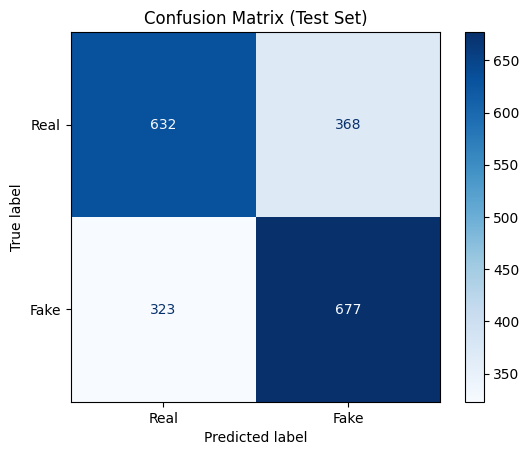

In [10]:
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [11]:
def predict_image(image_path):
    clf = joblib.load("real_fake_classifier.pkl")
    features = extract_features(image_path)
    prediction = clf.predict([features])[0]
    print(f"🔍 Prediction for '{image_path}': {'Fake 🤖' if prediction == 1 else 'Real 🧑'}")


In [13]:
predict_image("/content/fakeface/real_vs_fake/real-vs-fake/valid/fake/00483R5CC4.jpg")

/usr/local/lib/python3.11/dist-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


🔍 Prediction for '/content/fakeface/real_vs_fake/real-vs-fake/valid/fake/00483R5CC4.jpg': Real 🧑
